# Import Libraries

In [33]:
import torch
from torch.utils.data import DataLoader, random_split, Subset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import kagglehub
from tqdm import tqdm
import matplotlib.pyplot as plt

# Prepare Data

In [3]:
# Download latest version of data
path = kagglehub.dataset_download("lexset/synthetic-asl-alphabet")

print("Path to dataset files:", path)

Path to dataset files: /Users/anabellafalk/.cache/kagglehub/datasets/lexset/synthetic-asl-alphabet/versions/3


In [138]:
# Initialize transformation: format as tensor, normalize
transform_tr = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5] 
        )
    ])

In [222]:
# Load data folder
dat = torchvision.datasets.ImageFolder(
    root = path + "/Train_Alphabet",
    transform = transform_tr)

### Subset Data

In [223]:
# Drop J and Z
to_drop = ['J','Z']

dat.imgs = dat.imgs[0:10*900] + [i for i in dat.imgs[11*900:26*900]]
dat.samples = dat.samples[0:10*900] + [(i,l-1) for i,l in dat.samples[11*900:26*900]]
dat.targets = dat.targets[0:10*900] + [i-1 for i in dat.targets[11*900:26*900]]
dat.classes = [i for i in dat.classes if i not in to_drop ]

In [224]:
dat.class_to_idx = {
    'A': 0,
    'B': 1,
    'Blank': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
    'H': 8,
    'I': 9,
    'K': 10,
    'L': 11,
    'M': 12,
    'N': 13,
    'O': 14,
    'P': 15,
    'Q': 16,
    'R': 17,
    'S': 18,
    'T': 19,
    'U': 20,
    'V': 21,
    'W': 22,
    'X': 23,
    'Y': 24
 }

In [225]:
len(dat.targets) == len(dat.samples) and len(dat.targets) == len(dat.imgs) and len(dat.imgs) == len(dat) and len(dat) == 900*25

True

In [226]:
len(dat.classes) == 25

True

### Train-Val Split

In [227]:
# Split data
ratio_tr = 0.8
ratio_val = 0.2

size_tr = int(len(dat) * ratio_tr)
size_val = len(dat) - size_tr

dat_tr, dat_val = random_split(dat, [size_tr, size_val])

In [228]:
BATCH_SIZE = 64

# Load image data from folder
loader_tr = DataLoader(dat_tr, batch_size=BATCH_SIZE, shuffle=True)

loader_val = DataLoader(dat_val, batch_size=BATCH_SIZE, shuffle = False)

In [229]:
# Iterate through image data
images, labels = next(iter(loader_tr))

In [230]:
labels

tensor([18, 14,  7, 17,  1, 13, 15, 16,  3, 22, 18,  6, 15, 13, 17, 22, 21, 19,
         9, 12, 18,  9, 23, 21, 23, 21, 23, 11, 22,  6,  3, 12, 19, 12, 21,  7,
         3, 21, 15,  2, 23, 14, 14,  1, 23, 13,  8,  5,  3,  3, 22, 12,  3,  0,
         0,  1, 21,  8,  7, 22, 14,  5, 21,  1])

In [231]:
# size of batch, 3 (RGB), 512, 513 (pixel dims, should be 512x512?)
images.shape

torch.Size([64, 3, 512, 513])

### View Example Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


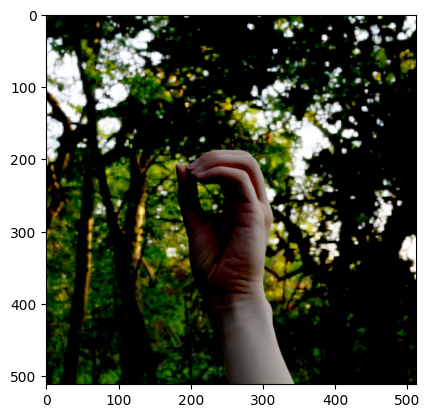

Label: 14


In [232]:
# Present image
i = 1
img = images[i].squeeze()
img = img.permute(1, 2, 0)  
label = labels[i]

plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [233]:
# Label mapping
dat.class_to_idx

{'A': 0,
 'B': 1,
 'Blank': 2,
 'C': 3,
 'D': 4,
 'E': 5,
 'F': 6,
 'G': 7,
 'H': 8,
 'I': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24}

# Fit Model

In [234]:
import torch.nn as nn
import torch.optim as optim 

In [235]:
# Initialize Conv NN
num_classes = 25

# Note: output channels are arbitrary
conv_model = nn.Sequential(
        # 3 input channels for RGB
        nn.Conv2d(3, 10, kernel_size = 3, stride = 2), 
        nn.ReLU(),
        nn.MaxPool2d(2), 
        # output dim ~128
        
        nn.Conv2d(10, 20, kernel_size = 3, stride = 2),
        nn.ReLU(),
        nn.MaxPool2d(2),
        # output dim ~32

        nn.Conv2d(20, 25, kernel_size = 3, stride = 2),
        nn.ReLU(),
        nn.MaxPool2d(2),
        # output dim 7

        nn.Flatten(),
        nn.Linear(25*7*7, 400),
        nn.ReLU(),

        nn.Linear(400, num_classes)
    )

In [236]:
# Initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_model.parameters())

In [237]:
# Fit model on data
# NUM_EPOCH = 2
# for epoch in range(NUM_EPOCH):
count = 0
curr_loss = 0
for i, data in tqdm(enumerate(loader_tr)):
    images, labels = data

    optimizer.zero_grad()

    outputs = conv_model(images)
    loss = criterion(outputs, labels)
    
    loss.backward()
    optimizer.step()
    
    count += 1
    curr_loss += loss.item()
    if count % 25 == 0:
        print("loss: " + str(curr_loss))
        curr_loss = 0

25it [00:49,  1.94s/it]

loss: 80.50500392913818


50it [01:39,  1.96s/it]

loss: 79.74931502342224


75it [02:30,  2.11s/it]

loss: 74.86591053009033


100it [03:22,  2.11s/it]

loss: 59.240508913993835


125it [04:12,  1.98s/it]

loss: 46.26423954963684


150it [05:03,  2.07s/it]

loss: 38.73733639717102


175it [05:54,  2.01s/it]

loss: 32.99867057800293


200it [06:44,  2.02s/it]

loss: 29.724114656448364


225it [07:36,  2.05s/it]

loss: 26.446943819522858


250it [08:27,  2.03s/it]

loss: 23.527296781539917


275it [09:17,  1.77s/it]

loss: 21.384094178676605


282it [09:28,  2.02s/it]


# Evaluate Model

In [ ]:
# Train data
correct = 0
total = 0

for i, data in tqdm(enumerate(loader_tr)):
    images, labels = data

    outputs = conv_model(images)
    _, predicted = torch.max(outputs, 1)

    correct += (predicted == labels).sum().item()
    total += labels.shape[0]

print("Accuracy: " + str(correct / total))

282it [07:35,  1.62s/it]

Accuracy: 0.8092777777777778


In [239]:
# Validation data
correct = 0
total = 0

for i, data in tqdm(enumerate(loader_val)):
    images, labels = data

    outputs = conv_model(images)
    _, predicted = torch.max(outputs, 1)

    correct += (predicted == labels).sum().item()
    total += labels.shape[0]

print("Accuracy: " + str(correct / total))

71it [01:55,  1.63s/it]

Accuracy: 0.7882222222222223


In [ ]:
# Create reverse mapping
reverse_map = {dat.class_to_idx[c]: c for c in dat.class_to_idx.keys()}

In [249]:
# Per class accuracy
correct = {c:0 for c in dat.classes}
total = {c:0 for c in dat.classes}

for i, data in tqdm(enumerate(loader_val)):
    images, labels = data

    outputs = conv_model(images)
    _, predicted = torch.max(outputs, 1)

    for lab, pred in zip(labels, predicted):
        if lab == pred:
            correct[reverse_map[lab.item()]] += 1
        total[reverse_map[lab.item()]] += 1

for c in correct.keys():
    print(c + " Accuracy: " + str(correct[c] / total[c]))

71it [01:45,  1.49s/it]

A Accuracy: 0.5897435897435898
B Accuracy: 0.8540540540540541
Blank Accuracy: 0.8883495145631068
C Accuracy: 0.9239130434782609
D Accuracy: 0.8010752688172043
E Accuracy: 0.6918918918918919
F Accuracy: 0.7936507936507936
G Accuracy: 0.8070175438596491
H Accuracy: 0.9611111111111111
I Accuracy: 0.8848167539267016
K Accuracy: 0.8378378378378378
L Accuracy: 0.8858695652173914
M Accuracy: 0.5976331360946746
N Accuracy: 0.6467065868263473
O Accuracy: 0.7931034482758621
P Accuracy: 0.8306878306878307
Q Accuracy: 0.7790055248618785
R Accuracy: 0.834319526627219
S Accuracy: 0.7160493827160493
T Accuracy: 0.7569060773480663
U Accuracy: 0.6395348837209303
V Accuracy: 0.6477987421383647
W Accuracy: 0.8020304568527918
X Accuracy: 0.9256756756756757
Y Accuracy: 0.7801047120418848
